In [ ]:
import os
os.environ['PATH'] = '/scratch/smp/uqsmac12/.conda/env/lit_torch_gp/bin:' + os.environ['PATH']

In [ ]:
!which python

In [1]:
import os
from anndata import read_h5ad
import numpy as np
import pandas as pd
import os
import torch

from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn import functional as F

from torch import optim, nn, utils, Tensor
from torchvision.datasets import MNIST
from torchvision import datasets, transforms
from torchvision.io import read_image
# from torchvision.transforms import ToTensor
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping



/scratch/smp/uqsmac12/.conda/env/lit_torch_gp/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# update the location where models will be saved to
if torch.hub.get_dir() == '/clusterdata/uqsmac12/.cache/torch/hub':
    torch.hub.set_dir('/scratch/smp/uqsmac12/.cache/torch/hub')

In [4]:
torch.cuda.is_available()

True

In [7]:
DIR_DATA = '/scratch/smp/uqsmac12/stimage2_data'

# DIR_WANDB = DIR_DATA
DIR_TILES = '/scratch/smp/uqsmac12/dataset_breast_cancer_9visium'
DIR_ANNDATA_PROCESSED = '/scratch/smp/uqsmac12/dataset_breast_cancer_9visium'
file_processed_alex_data = 'all_adata.h5ad'
# DIR_PROCESSED_DATA = '/afm03/Q2/Q2051/STimage_project/STimage_dataset/PROCESSED/dataset_breast_cancer_9visium'
DIR_RAW_DATA = '/afm03/Q2/Q2051/STimage_project/STimage_dataset/RAW/Alex_NatGen_6BreastCancer'
DIR_RAW_METADATA = os.path.join(DIR_RAW_DATA, 'metadata')

DIR_CHECKPOINTS = os.path.join(DIR_DATA, 'checkpoints')
# location to save data
DIR_PROCESSED_DATASET = os.path.join(DIR_DATA, 'data_processed')

## load data

In [8]:
adata_all = read_h5ad(os.path.join(DIR_ANNDATA_PROCESSED, file_processed_alex_data))

## Get image and RNA data

In [9]:
# update metadata for annadata such that it maps to the correct location
adata_all.obs["tile_path"] = adata_all.obs.tile_path.map(
    lambda x: x.replace("/clusterdata/uqxtan9/Xiao/breast_cancer_9visium",
                        DIR_TILES))

In [10]:
# ensure change of datapath executed correctly
assert 'uqsmac12' in adata_all.obs['tile_path'][0]

In [11]:
gene_list = ["COX6C","TTLL12", "PABPC1", "GNAS", "HSP90AB1", "TFF3", "ATP1A1", "B2M", "FASN", "SPARC", "CD74", "CD63", "CD24", "CD81"]

In [13]:
adata_all.obs['library_id'].value_counts()

1160920F    4783
1142243F    4704
block2      3770
block1      3519
FFPE        2338
CID4290     2300
CID4465     1106
CID44971    1046
CID4535     1012
Name: library_id, dtype: int64

In [137]:
df_rna = adata_all.to_df()

In [138]:
df_rna.shape

(24578, 14664)

In [139]:
X_counts = df_rna.values

In [140]:
library_size = X_counts.sum(axis=1).reshape(-1,1)

In [141]:
X_log_cpt = np.log(X_counts * 1e3 / library_size+1)

In [142]:
df_rna.index

Index(['GATAAGGGACGATTAG-1-1142243F', 'TGTTGGCTGGCGGAAG-1-1142243F',
       'GCGAGGGACTGCTAGA-1-1142243F', 'GCGCGTTTAAATCGTA-1-1142243F',
       'ATCTATCGATGATCAA-1-1142243F', 'CGGTAACAAGATACAT-1-1142243F',
       'TCGCCGGAGAGTCTTA-1-1142243F', 'GGAGGAGTGTGTTTAT-1-1142243F',
       'TTAGGTGTGACTGGTC-1-1142243F', 'CAGGGCTAACGAAACC-1-1142243F',
       ...
       'TTGTGCAGCCACGTCA-1-FFPE', 'TTGTGGCCCTGACAGT-1-FFPE',
       'TTGTGGTAGGAGGGAT-1-FFPE', 'TTGTGTTTCCCGAAAG-1-FFPE',
       'TTGTTAGCAAATTCGA-1-FFPE', 'TTGTTCAGTGTGCTAC-1-FFPE',
       'TTGTTGTGTGTCAAGA-1-FFPE', 'TTGTTTCACATCCAGG-1-FFPE',
       'TTGTTTCATTAGTCTA-1-FFPE', 'TTGTTTCCATACAACT-1-FFPE'],
      dtype='object', length=24578)

In [143]:
df_rna = pd.DataFrame(X_log_cpt, columns=df_rna.columns, index=df_rna.index)

In [144]:
# select genes of interest
df_rna = df_rna[gene_list]

In [14]:
# X_counts = np.exp(adata_all.to_df().values)

In [15]:
# X_counts.shape

(24578, 14664)

## Get class labels

In [16]:
dict_meta = {}
dict_meta_counts = {}
unique_classes = set()
list_library = []
for fname in os.listdir(DIR_RAW_METADATA):
    if fname[0] != '.':
        library_id = fname.split('_')[0]
        list_library.append(library_id)
        dict_meta[library_id] = pd.read_csv(os.path.join(DIR_RAW_METADATA, fname))
        dict_meta[library_id]['library'] = library_id
        dict_meta_counts[library_id] = dict_meta[library_id]['Classification'].value_counts()
        print(library_id)
        print(dict_meta[library_id]['Classification'].value_counts())
        unique_classes.update(set(dict_meta[library_id]['Classification'].unique()))
        print()

1142243F
Invasive cancer + stroma + lymphocytes    3627
Necrosis                                   568
Stroma                                     445
Artefact                                   119
Lymphocytes                                 15
TLS                                         10
Name: Classification, dtype: int64

1160920F
Invasive cancer + stroma + lymphocytes      3146
Stroma                                      1132
Normal glands + lymphocytes                  278
Lymphocytes                                  186
Adipose tissue                                83
Artefact                                      48
DCIS                                          12
Cancer trapped in lymphocyte aggregation       9
Name: Classification, dtype: int64

CID4290
Invasive cancer + stroma                  2082
Invasive cancer + stroma + lymphocytes     215
Stroma                                     122
Artefact                                     7
Name: Classification, dtype: int64

CID4

In [17]:
df_meta = pd.DataFrame(dict_meta_counts)
df_meta = df_meta.fillna(0)

In [18]:
df_meta

,1142243F,1160920F,CID4290,CID4535,CID44971,CID4465
Adipose tissue,0.0,83.0,0.0,8.0,0.0,0.0
Artefact,119.0,48.0,7.0,23.0,1.0,4.0
Cancer trapped in lymphocyte aggregation,0.0,9.0,0.0,0.0,0.0,0.0
DCIS,0.0,12.0,0.0,0.0,273.0,0.0
Invasive cancer,0.0,0.0,0.0,418.0,0.0,0.0
Invasive cancer + adipose tissue + lymphocytes,0.0,0.0,0.0,3.0,0.0,0.0
Invasive cancer + lymphocytes,0.0,0.0,0.0,361.0,317.0,0.0
Invasive cancer + stroma,0.0,0.0,2082.0,0.0,0.0,0.0
Invasive cancer + stroma + lymphocytes,3627.0,3146.0,215.0,0.0,0.0,1131.0
Lymphocytes,15.0,186.0,0.0,69.0,81.0,0.0


In [20]:
mapper_celltype_to_binary = { "Artefact": 0, "Lymphocytes": 0, "Stroma": 0, "DCIS": 0, "Invasive cancer + lymphocytes": 1, "Normal + stroma + lymphocytes": 0, "Stroma + adipose tissue": 0,
    "Invasive cancer + stroma + lymphocytes": 1, "Normal duct": 0, "Adipose tissue": 0, "Invasive cancer": 1, "Invasive cancer + adipose + lymphocytes": 1, "Uncertain": 0,
    "Invasive cancer + stroma": 1, "Cancer trapped in lymphocyte aggregation": 1, "Normal glands + lymphocytes": 0, "Necrosis": 0, "TLS": 0}

In [21]:
dict_meta[library_id]['cancer_class'] = dict_meta[library_id]['Classification'].map(mapper_celltype_to_binary)

In [22]:
dict_meta[library_id]['cancer_class'].value_counts()

1    1131
0      80
Name: cancer_class, dtype: int64

In [23]:
for library_id in dict_meta.keys():
    # Map to binary classification. 
    dict_meta[library_id]['cancer_class'] = dict_meta[library_id]['Classification'].map(mapper_celltype_to_binary)
    # Fill NA. 
    dict_meta[library_id]['cancer_class'] = dict_meta[library_id]['cancer_class'].fillna(0)
    print(library_id)
    print(dict_meta[library_id]['cancer_class'].value_counts())
    print(dict_meta[library_id]['cancer_class'].isna().sum())
    print()

1142243F
1    3627
0    1157
Name: cancer_class, dtype: int64
0

1160920F
1.0    3155
0.0    1740
Name: cancer_class, dtype: int64
0

CID4290
1.0    2297
0.0     135
Name: cancer_class, dtype: int64
0

CID4535
1.0    779
0.0    348
Name: cancer_class, dtype: int64
0

CID44971
0.0    845
1.0    317
Name: cancer_class, dtype: int64
0

CID4465
1    1131
0      80
Name: cancer_class, dtype: int64
0



In [24]:
# create index for the labels
for library_id in dict_meta.keys():
    dict_meta[library_id].index = dict_meta[library_id]['Unnamed: 0'] + '-' + library_id

In [27]:
df_meta = pd.concat(list(dict_meta.values()), axis=0)

In [28]:
df_meta.head()

,Unnamed: 0,nCount_RNA,nFeature_RNA,patientid,subtype,Classification,library,cancer_class
Unnamed: 0,,,,,,,,
TACCGATCCAACACTT-1-1142243F,TACCGATCCAACACTT-1,4073,2071,1142243F,TNBC,Artefact,1142243F,0.0
GATAAGGGACGATTAG-1-1142243F,GATAAGGGACGATTAG-1,4628,2320,1142243F,TNBC,Artefact,1142243F,0.0
TGTTGGCTGGCGGAAG-1-1142243F,TGTTGGCTGGCGGAAG-1,5116,2494,1142243F,TNBC,Artefact,1142243F,0.0
GCGAGGGACTGCTAGA-1-1142243F,GCGAGGGACTGCTAGA-1,8170,3464,1142243F,TNBC,Artefact,1142243F,0.0
GCGCGTTTAAATCGTA-1-1142243F,GCGCGTTTAAATCGTA-1,7534,3345,1142243F,TNBC,Artefact,1142243F,0.0


In [154]:
df_adata = adata_all.obs.copy()

In [155]:
# merge data
df_adata = df_adata.merge(df_meta, how='left', left_index=True, right_index=True)

In [156]:
# drop instances not in the tissue
df_adata = df_adata[df_adata['in_tissue'] == 1]

## Image and RNA dataframe

In [157]:
df_adata = df_adata.merge(df_rna, how='left', left_index=True, right_index=True)

In [158]:
df_adata.head()

,in_tissue,array_row,array_col,imagecol,imagerow,tile_tissue_mask_path,tissue_area,tile_path,library_id,Unnamed: 0,...,HSP90AB1,TFF3,ATP1A1,B2M,FASN,SPARC,CD74,CD63,CD24,CD81
GATAAGGGACGATTAG-1-1142243F,1,1,3,12601,4511,/tmp/1142243F_tissue_mask/1142243F-12601-4511-...,0.733437,/scratch/smp/uqsmac12/dataset_breast_cancer_9v...,1142243F,GATAAGGGACGATTAG-1,...,0.806845,0.0,0.602795,0.837728,0.000000,0.504136,0.602795,0.602795,0.909376,0.346146
TGTTGGCTGGCGGAAG-1-1142243F,1,1,5,12872,4512,/tmp/1142243F_tissue_mask/1142243F-12872-4512-...,0.878391,/scratch/smp/uqsmac12/dataset_breast_cancer_9v...,1142243F,TGTTGGCTGGCGGAAG-1,...,0.722235,0.0,0.562166,0.722235,0.000000,0.629094,0.722235,0.680637,0.468691,0.629094
GCGAGGGACTGCTAGA-1-1142243F,1,1,7,13144,4513,/tmp/1142243F_tissue_mask/1142243F-13144-4513-...,0.884632,/scratch/smp/uqsmac12/dataset_breast_cancer_9v...,1142243F,GCGAGGGACTGCTAGA-1,...,0.623886,0.0,0.405969,0.623886,0.223446,0.640588,0.640588,0.499088,0.584269,0.405969
GCGCGTTTAAATCGTA-1-1142243F,1,1,9,13416,4514,/tmp/1142243F_tissue_mask/1142243F-13416-4514-...,0.813425,/scratch/smp/uqsmac12/dataset_breast_cancer_9v...,1142243F,GCGCGTTTAAATCGTA-1,...,0.584348,0.0,0.478962,0.696867,0.350229,0.667114,0.555519,0.478962,0.696867,0.555519
ATCTATCGATGATCAA-1-1142243F,1,3,3,12599,4984,/tmp/1142243F_tissue_mask/1142243F-12599-4984-...,0.879218,/scratch/smp/uqsmac12/dataset_breast_cancer_9v...,1142243F,ATCTATCGATGATCAA-1,...,0.668963,0.0,0.252037,0.883805,0.252037,0.688951,0.554439,0.554439,0.688951,0.620540


In [159]:
df_adata.groupby('library_id')[g].agg(func=['min', 'median', 'max', 'mean'])

,min,median,max,mean
library_id,,,,
1142243F,0.0,0.526123,1.881856,0.509522
1160920F,0.0,0.517391,1.860068,0.535184
CID4290,0.0,0.420986,1.745939,0.424370
CID4465,0.0,0.416416,1.479316,0.421191
CID44971,0.0,0.397487,1.311405,0.404954
CID4535,0.0,0.354996,1.280810,0.353529
block1,0.0,0.371561,1.294898,0.401335
block2,0.0,0.383846,1.364818,0.407764
FFPE,0.0,0.395886,1.110433,0.414325


In [160]:
library_ids = df_adata['library_id'].unique()

In [ ]:
# fig, ax = plt.subplots(len(library_ids), len(gene_list), figsize=(20,20))

# for i, lib_id in enumerate(library_ids):
#     for j, col in enumerate(gene_list):
#         subset = df_adata[df_adata['library_id'] == lib_id][col]
#         ax[i][j].hist(subset, bins=20, edgecolor='k')
#         ax[i][j].set_title(f"{lib_id} - {col}")
        
# plt.tight_layout()
# plt.show()

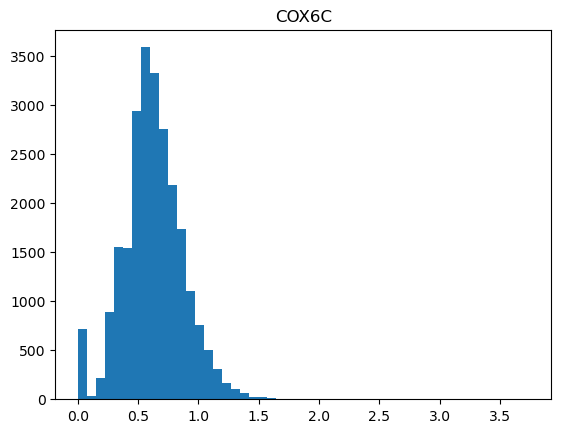

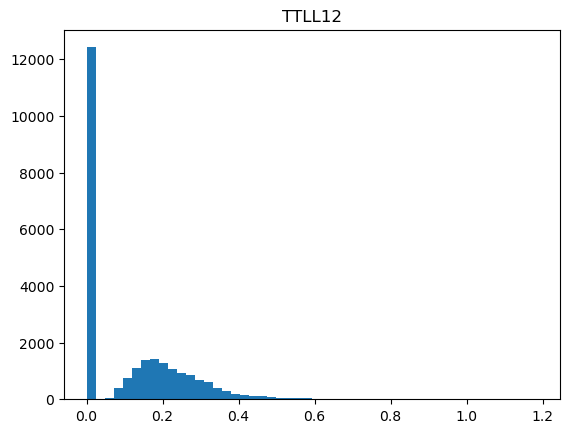

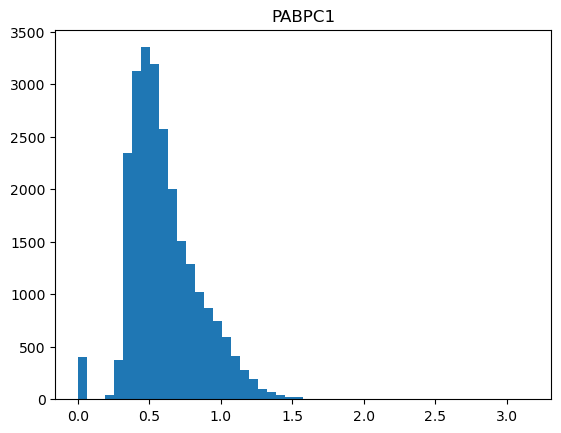

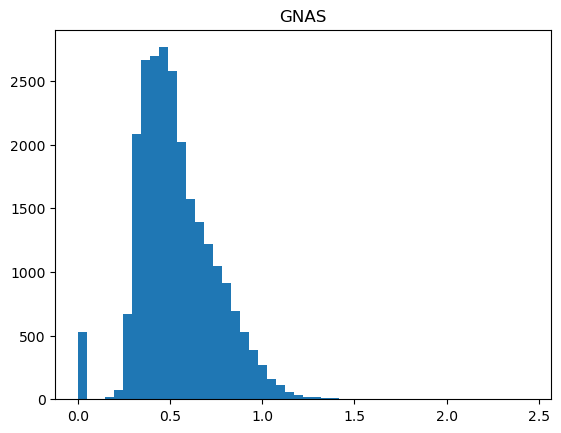

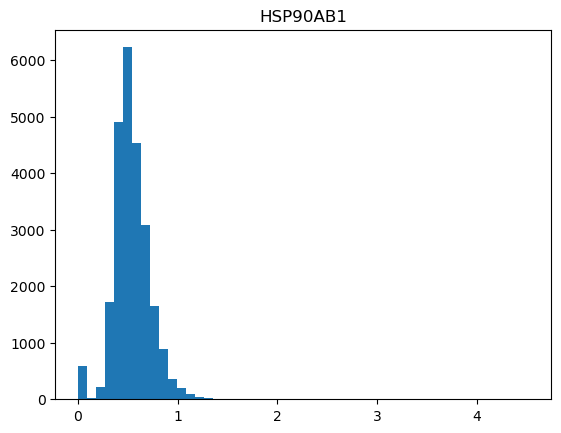

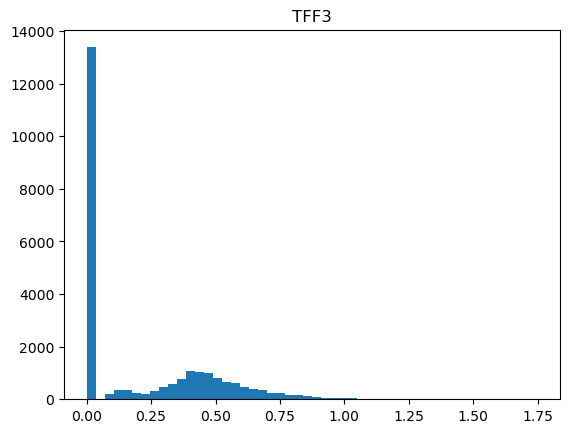

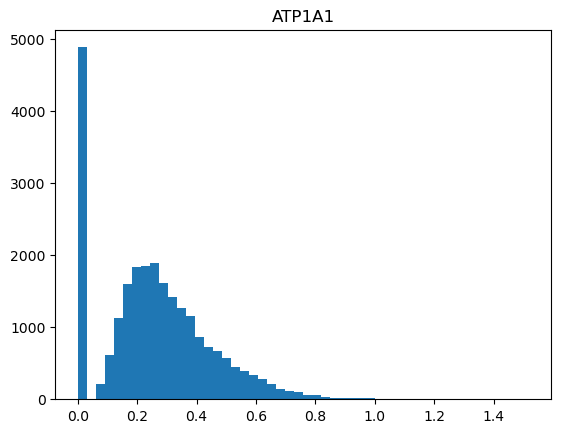

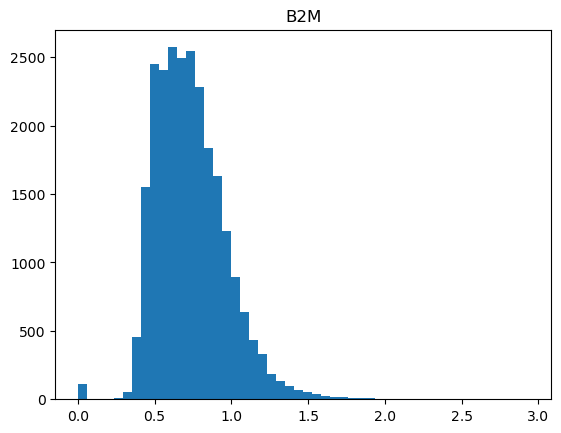

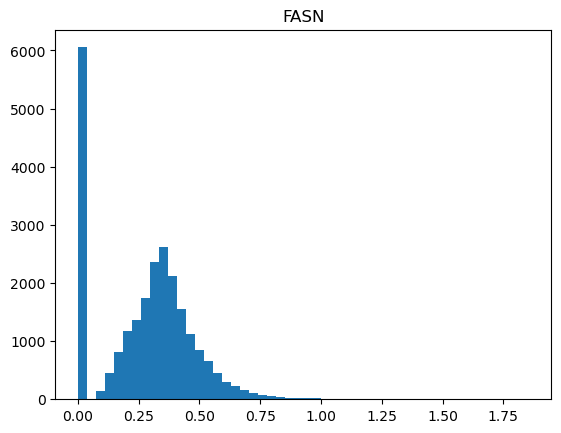

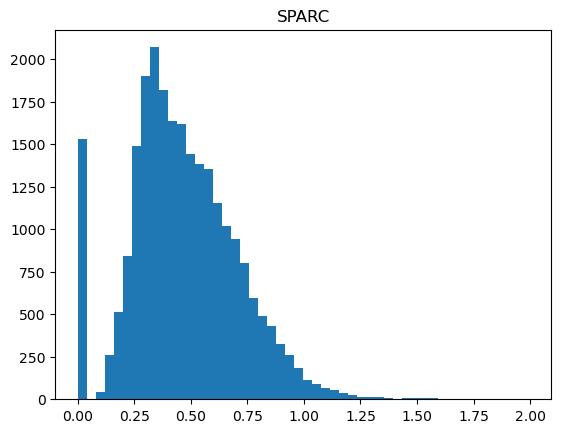

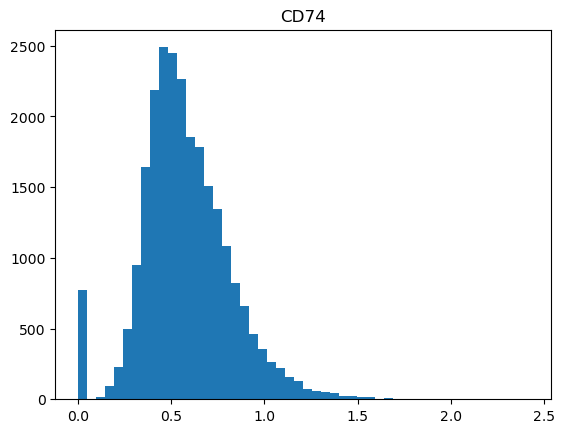

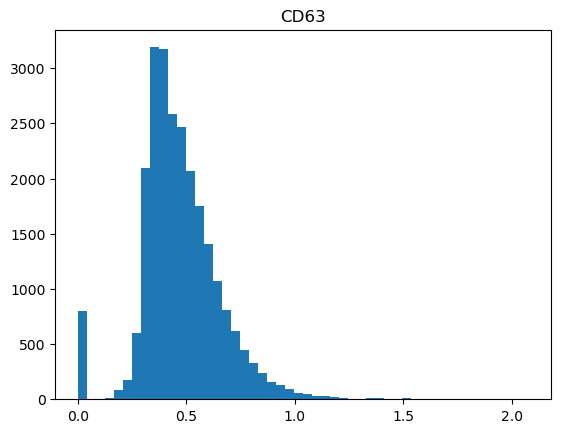

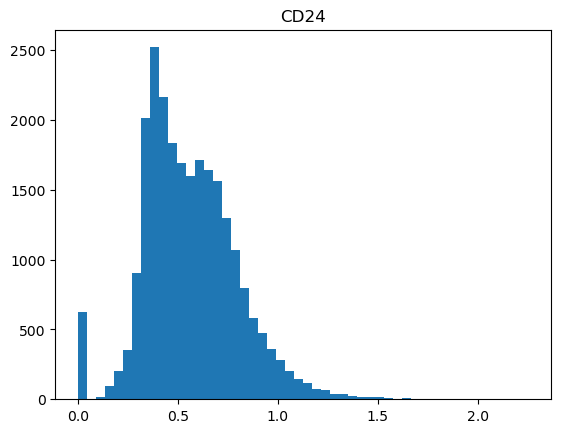

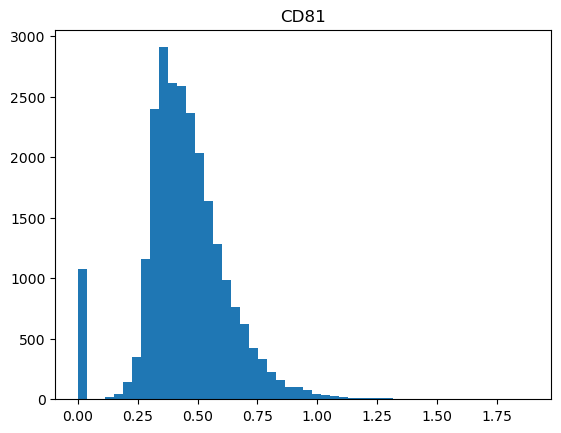

In [162]:
for g in gene_list:
    plt.hist(df_adata[g].values, bins=50)
    plt.title(g)
    plt.show()

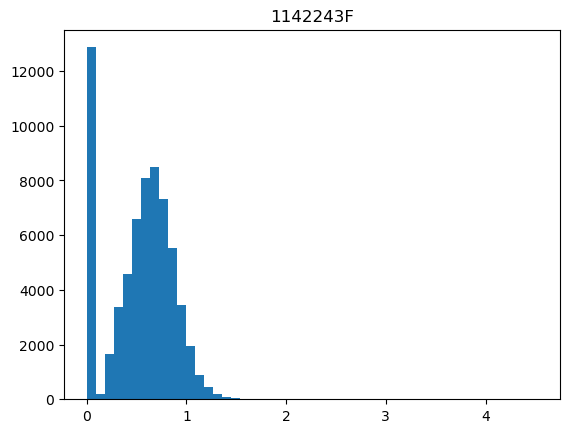

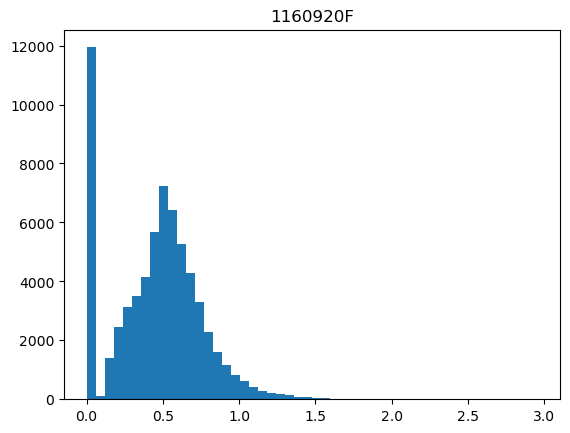

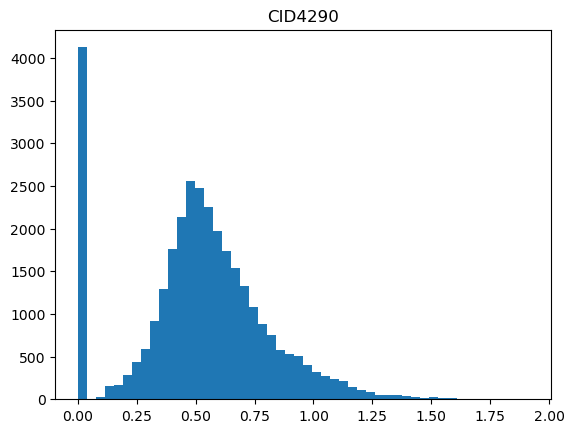

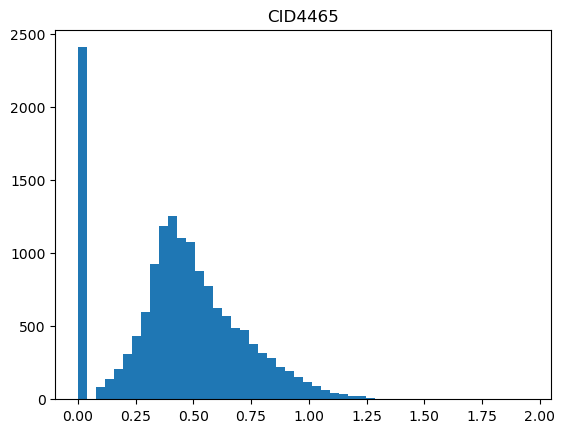

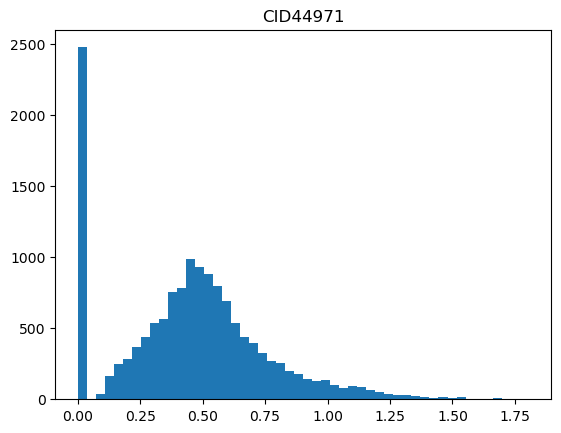

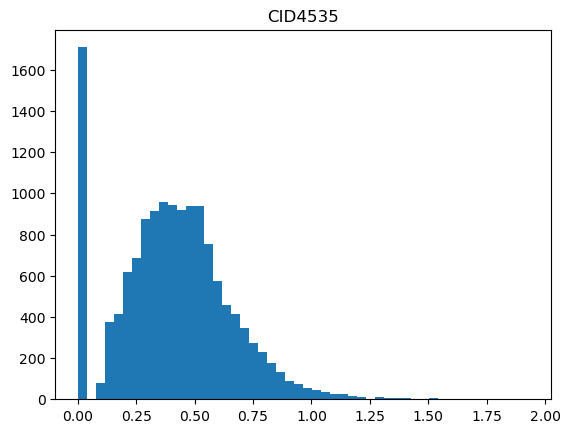

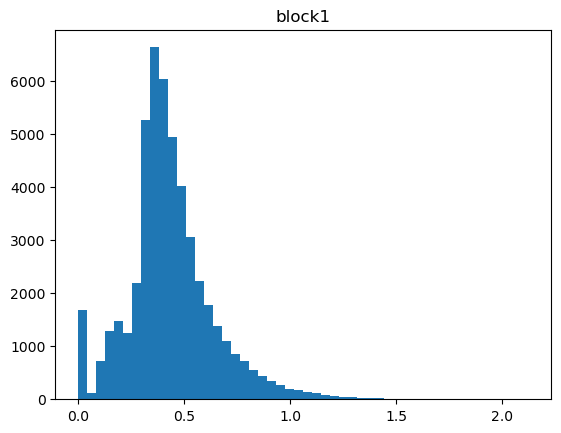

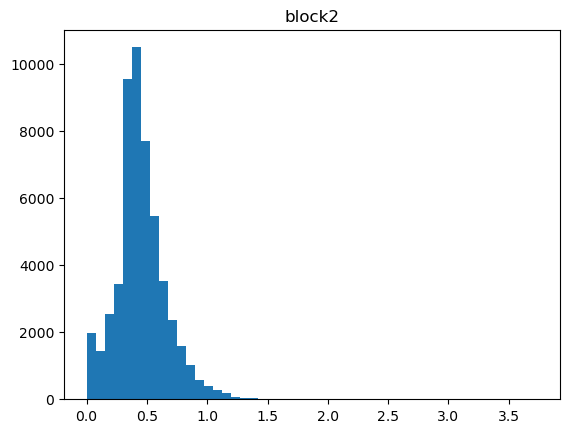

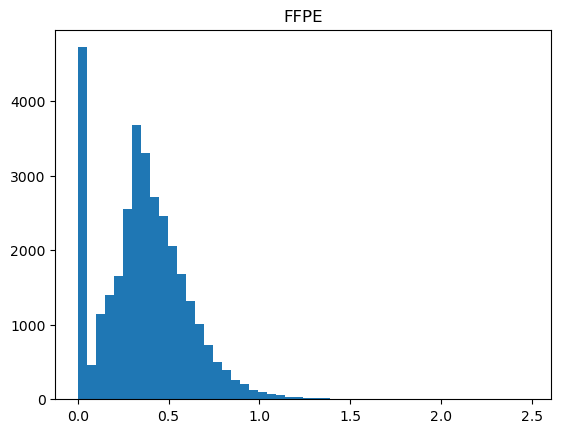

In [163]:
for lib_id in library_ids:
    subset = df_adata[df_adata['library_id'] == lib_id][gene_list]
    subset = subset.values.reshape(-1,1)
    plt.hist(subset, bins=50)
    plt.title(lib_id)
    plt.show()
    del subset

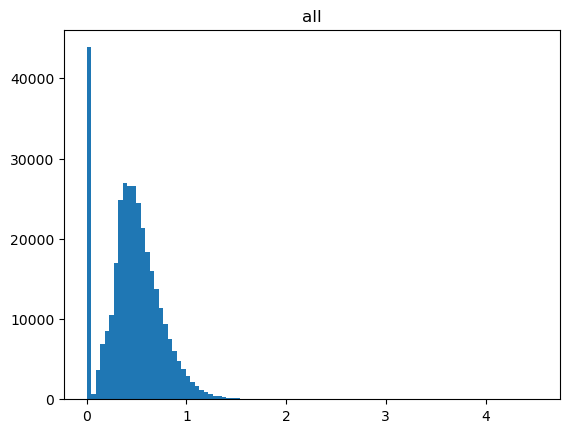

In [165]:
subset = df_adata[gene_list]
subset = subset.values.reshape(-1,1)
plt.hist(subset, bins=100)
plt.title('all')
plt.show()

# save out dataframe hosting rna, images, and labels

In [168]:
df_adata.to_csv(os.path.join(DIR_PROCESSED_DATASET, 'df_adata_rna_logcpt_images_labels_visium9.csv'))

## Image, RNA, and class label dataframe

In [40]:
# drop instances without labels
df_adata = df_adata[df_adata['cancer_class'].notna()]

In [44]:
df_adata['cancer_class'].dtype

dtype('int64')

In [169]:
class VisiumClassificationDataset(Dataset):
    """
    X (image) -> y (class)
    """
    def __init__(self, df_data, transform=None, target_transform=None):
        self.df_data = df_data
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.df_data)
    
    def __getitem__(self, idx):
        idx_name = self.df_data.index[idx]
        X_img = self.load_img(idx_name)
#         y = self.get_expression(idx_name)
        c = self.get_class(idx_name)
        print(c)
        return X_img, c
    
    def load_img(self, key):
        """load an image"""
        img_path = self.df_data.loc[key, 'tile_path']
        X_img = read_image(img_path)
            
        if self.transform:
            X_img = self.transform(X_img)
        
        return X_img
    
#     def get_expression(self, key):
#         y = torch.Tensor(adata_all[idx_name, gene_list].to_df().values)
        
#         if self.target_transform:
#             y = self.target_transform(y)
        
#         return y
    
    def get_class(self, key):
        c = self.df_data.loc[key, 'cancer_class']
        print(c)
        return c

In [136]:
# split into train validation and test

In [137]:
df_test = df_adata[df_adata['library'] == 'CID4465']
df_train = df_adata[df_adata['library'] != 'CID4465']

In [138]:
train_dataset = VisiumClassificationDataset(df_train)

In [139]:
test_dataset = VisiumClassificationDataset(df_test)

In [ ]:
kwargs = {"num_workers": 4, "pin_memory": True}

In [140]:
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [141]:
# train DKL model

In [ ]:
feature_extractor = WideResNet(
        input_size,
        hparams.spectral_conv,
        hparams.spectral_bn,
        dropout_rate=hparams.dropout_rate,
        coeff=hparams.coeff,
        n_power_iterations=hparams.n_power_iterations,
    )

In [ ]:
initial_inducing_points, initial_lengthscale = dkl.initial_values(
    train_dataset, feature_extractor, hparams.n_inducing_points
)

gp = dkl.GP(
    num_outputs=num_classes,
    initial_lengthscale=initial_lengthscale,
    initial_inducing_points=initial_inducing_points,
    kernel=hparams.kernel,
)

model = dkl.DKL(feature_extractor, gp)

likelihood = SoftmaxLikelihood(num_classes=num_classes, mixing_weights=False)
likelihood = likelihood.cuda()

elbo_fn = VariationalELBO(likelihood, gp, num_data=len(train_dataset))
loss_fn = lambda x, y: -elbo_fn(x, y)

In [ ]:
model = model.cuda()

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=hparams.learning_rate,
    momentum=0.9,
    weight_decay=hparams.weight_decay,
)

milestones = [60, 120, 160]

scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=milestones, gamma=0.2
)

In [ ]:
def step(engine, batch):
    model.train()
    if not hparams.sngp:
        likelihood.train()

    optimizer.zero_grad()

    x, y = batch
    x, y = x.cuda(), y.cuda()

    y_pred = model(x)
    loss = loss_fn(y_pred, y)

    loss.backward()
    optimizer.step()

    return loss.item()

In [ ]:
def eval_step(engine, batch):
    model.eval()
    if not hparams.sngp:
        likelihood.eval()

    x, y = batch
    x, y = x.cuda(), y.cuda()

    with torch.no_grad():
        y_pred = model(x)

    return y_pred, y

In [ ]:
trainer = Engine(step)
evaluator = Engine(eval_step)

metric = Average()
metric.attach(trainer, "loss")

In [ ]:
def output_transform(output):
    y_pred, y = output

    # Sample softmax values independently for classification at test time
    y_pred = y_pred.to_data_independent_dist()

    # The mean here is over likelihood samples
    y_pred = likelihood(y_pred).probs.mean(0)

    return y_pred, y



In [ ]:
metric = Accuracy(output_transform=output_transform)
metric.attach(evaluator, "accuracy")

In [ ]:
metric = Loss(lambda y_pred, y: -likelihood.expected_log_prob(y, y_pred).mean())
metric.attach(evaluator, "loss")

In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_results(trainer):
    metrics = trainer.state.metrics
    train_loss = metrics["loss"]

    result = f"Train - Epoch: {trainer.state.epoch} "
    if hparams.sngp:
        result += f"Loss: {train_loss:.2f} "
    else:
        result += f"ELBO: {train_loss:.2f} "
    print(result)

    writer.add_scalar("Loss/train", train_loss, trainer.state.epoch)

    if hparams.spectral_conv:
        for name, layer in model.feature_extractor.named_modules():
            if isinstance(layer, torch.nn.Conv2d):
                writer.add_scalar(
                    f"sigma/{name}", layer.weight_sigma, trainer.state.epoch
                )

    if trainer.state.epoch > 150 and trainer.state.epoch % 5 == 0:
        _, auroc, aupr = get_ood_metrics(
            hparams.dataset, "SVHN", model, likelihood, hparams.data_root
        )
        print(f"OoD Metrics - AUROC: {auroc}, AUPR: {aupr}")
        writer.add_scalar("OoD/auroc", auroc, trainer.state.epoch)
        writer.add_scalar("OoD/auprc", aupr, trainer.state.epoch)

    evaluator.run(test_loader)
    metrics = evaluator.state.metrics
    acc = metrics["accuracy"]
    test_loss = metrics["loss"]

    result = f"Test - Epoch: {trainer.state.epoch} "
    if hparams.sngp:
        result += f"Loss: {test_loss:.2f} "
    else:
        result += f"NLL: {test_loss:.2f} "
    result += f"Acc: {acc:.4f} "
    print(result)
    writer.add_scalar("Loss/test", test_loss, trainer.state.epoch)
    writer.add_scalar("Accuracy/test", acc, trainer.state.epoch)

    scheduler.step()

In [ ]:
pbar = ProgressBar(dynamic_ncols=True)
pbar.attach(trainer)

trainer.run(train_loader, max_epochs=200)

# Done training - time to evaluate
results = {}

evaluator.run(test_loader)
test_acc = evaluator.state.metrics["accuracy"]
test_loss = evaluator.state.metrics["loss"]
results["test_accuracy"] = test_acc
results["test_loss"] = test_loss

_, auroc, aupr = get_ood_metrics(
    hparams.dataset, "SVHN", model, likelihood, hparams.data_root
)
results["auroc_ood_svhn"] = auroc
results["aupr_ood_svhn"] = aupr

print(f"Final accuracy {results['test_accuracy']:.4f}")

results_json = json.dumps(results, indent=4, sort_keys=True)
(results_dir / "results.json").write_text(results_json)

torch.save(model.state_dict(), results_dir / "model.pt")
if likelihood is not None:
    torch.save(likelihood.state_dict(), results_dir / "likelihood.pt")

writer.close()